Disclaimer: this is not my code, I'm just trying new things and watching some tutorials

## Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras


## Linear Regression: Loading datasets

In [2]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## Linear Regression: Some plots

In [3]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


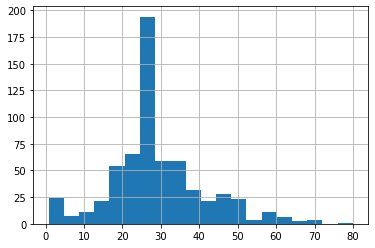

In [4]:
dftrain.age.hist(bins=20)

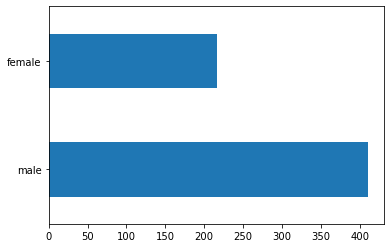

In [5]:
dftrain.sex.value_counts().plot(kind='barh')

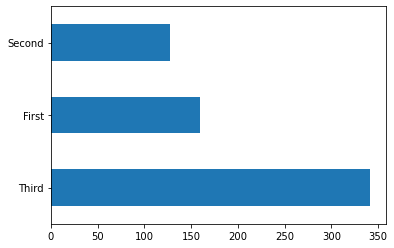

In [6]:
dftrain["class"].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

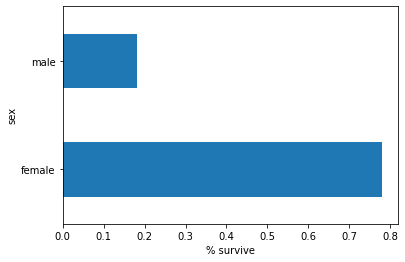

In [7]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## Linear Regression: Creating Special DataSets for TensorFlow

In [8]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))


In [9]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():  # inner function, this will be returned
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
        if shuffle:
            ds = ds.shuffle(1000)  # randomize order of data
        ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
        return ds  # return a batch of the dataset
    return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


## Linear Regression: Creating and running model

1. linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
2. linear_est.train(train_input_fn)
3. result = linear_est.evaluate(eval_input_fn)

In [10]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\WASILE~1\\AppData\\Local\\Temp\\tmp54wswhe9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.7462121


## Classification: Loading and creating datasets

In [12]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
train_y = train.pop('Species')
test_y = test.pop('Species')
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

In [13]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [14]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

In [15]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


## Classification: creating and running DNNclassifier model
1. classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns, hidden_units=[30, 10], n_classes=3)
2. classifier.train(input_fn=lambda: input_fn(train, train_y, training=True), steps=5000)
3. eval_result = classifier.evaluate(input_fn=lambda: input_fn(test, test_y, training=False))


In [16]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\WASILE~1\\AppData\\Local\\Temp\\tmp6jx7d8z2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [17]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# We include a lambda to avoid creating an inner function previously

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\WASILE~1\AppData\Local\Temp\tmp6jx7d8z2\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow

In [18]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-11T12:37:38Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\WASILE~1\AppData\Local\Temp\tmp6jx7d8z2\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.21520s
INFO:tensorflow:Finished evaluation at 2020-06-11-12:37:38
INFO:tensorflow:Saving dict for global step 500

## Classifier: Prediction

In [19]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
    valid = True
    while valid: 
        val = input(feature + ": ")
        if not val.isdigit(): valid = False

    predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))

Please type numeric values as prompted.
SepalLength: 1.1
SepalWidth: 1.1
PetalLength: 1.
PetalWidth: 1.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\WASILE~1\AppData\Local\Temp\tmp6jx7d8z2\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Versicolor" (39.9%)


## Hidden Markov Model: /datasets/

In [20]:
tfd = tfp.distributions  # making a shortcut for later on
initial_distribution = tfd.Categorical(probs=[0.8, 0.2])  # Refer to point 2 above
transition_distribution = tfd.Categorical(probs=[[0.3, 0.2],
                                                 [0.2, 0.8]])  # refer to points 3 and 4 above
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])  # refer to point 5 above

# the loc argument represents the mean and the scale is the standard devitation

## Hidden Markov Model: Creating model

In [21]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

In [22]:
mean = model.mean()

# due to the way TensorFlow works on a lower level we need to evaluate part of the graph
# from within a session to see the value of this tensor

# in the new version of tensorflow we need to use tf.compat.v1.Session() rather than just tf.Session()
with tf.compat.v1.Session() as sess:  
    print(mean.numpy())

[3.       7.2      8.88     9.552    9.820799 9.928319 9.971326]


## Neural Network: loading and creating data

In [23]:
fashion_mnist = keras.datasets.fashion_mnist  # load dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()  # split into tetsing and training

In [24]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images = test_images / 255.0

## Neural Network: creating network's layers, compiling and training/fitting

In [25]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # input layer (1)
    keras.layers.Dense(128, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(10, activation='softmax') # output layer (3)
])

In [26]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.fit(train_images, train_labels, epochs=5)  # we pass the data, labels and epochs and watch the magic!

Epoch 1/5
1875/1875 [==============================] - 2s 924us/step - loss: 0.4940 - accuracy: 0.8270
Epoch 2/5
1875/1875 [==============================] - 2s 925us/step - loss: 0.3746 - accuracy: 0.8648
Epoch 3/5
1875/1875 [==============================] - 2s 898us/step - loss: 0.3368 - accuracy: 0.8771
Epoch 4/5
1875/1875 [==============================] - 2s 890us/step - loss: 0.3130 - accuracy: 0.8860
Epoch 5/5
1875/1875 [==============================] - 2s 906us/step - loss: 0.2957 - accuracy: 0.8917


## Neural Network: checking accuracy on eval data

In [28]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1) 

print('Test accuracy:', test_acc)

313/313 [==============================] - 0s 950us/step - loss: 0.3764 - accuracy: 0.8624
Test accuracy: 0.8623999953269958


## Neural Network: Predictions

Pick a number: 1
Excpected: Pullover
Guess: Pullover


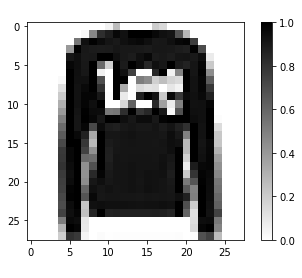

In [29]:
predictions = model.predict(test_images)

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    prediction = model.predict(np.array([image]))
    predicted_class = class_names[np.argmax(prediction)]
    print("Excpected:", class_names[correct_label])
    print("Guess:", predicted_class)
    show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
    plt.figure()
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title("Excpected: " + label)
    plt.xlabel("Guess: " + guess)
    plt.colorbar()
    plt.grid(False)
    plt.show()


def get_number():
    while True:
        num = input("Pick a number: ")
        if num.isdigit():
            num = int(num)
        if 0 <= num <= 1000:
            return int(num)
        else:
            print("Try again...")

num = get_number()
image = test_images[num]
label = test_labels[num]
predict(model, image, label)

## Convolutional Neural Network

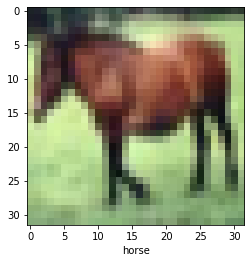

In [2]:
#  LOAD AND SPLIT DATASET
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Let's look at a one image
IMG_INDEX = 7  # change this to look at other images

plt.imshow(train_images[IMG_INDEX] ,cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [4]:
model.summary()  # let's have a look at our model so far

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=1, 
                    validation_data=(test_images, test_labels))

1563/1563 [==============================] - 5s 3ms/step - loss: 1.5140 - accuracy: 0.4467 - val_loss: 1.2159 - val_accuracy: 0.5674


In [7]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

313/313 - 0s - loss: 1.2159 - accuracy: 0.5674
0.5673999786376953


Using TensorFlow backend.


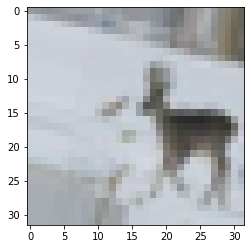

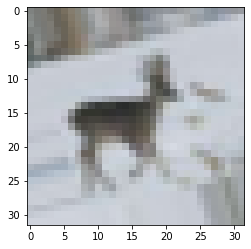

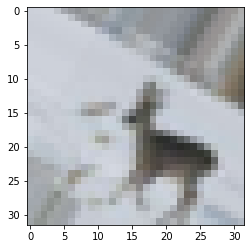

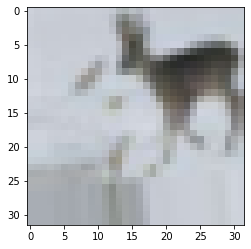

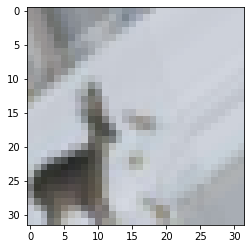

In [8]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# creates a data generator object that transforms images
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

# pick an image to transform
test_img = train_images[20]
img = image.img_to_array(test_img)  # convert image to numpy arry
img = img.reshape((1,) + img.shape)  # reshape image

i = 0

for batch in datagen.flow(img, save_prefix='test', save_format='jpeg'):  # this loops runs forever until we break, saving images to current directory with specified prefix
    plt.figure(i)
    plot = plt.imshow(image.img_to_array(batch[0]))
    i += 1
    if i > 4:  # show 4 images
        break

plt.show()


In [9]:
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [10]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

c:\users\wasilewski\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.microsoft.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Shuffling and writing examples to C:\Users\Wasilewski\tensorflow_datasets\cats_vs_dogs\4.0.0.incompleteDGU0K6\cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to C:\Users\Wasilewski\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.


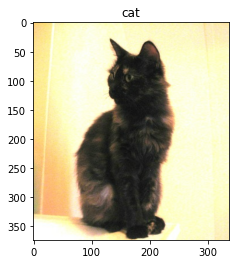

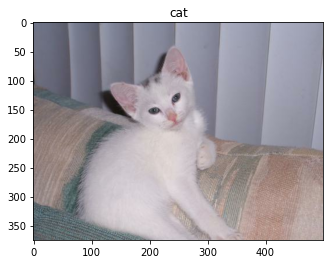

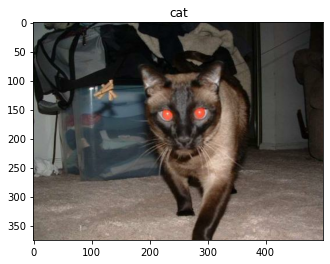

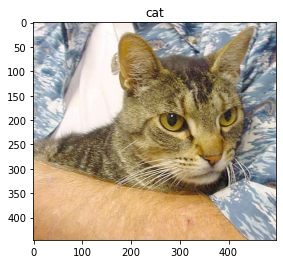

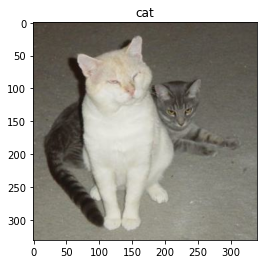

In [12]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels

# display 2 images from the dataset
for image, label in raw_train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [13]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [14]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

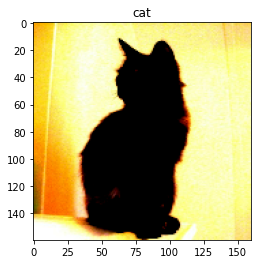

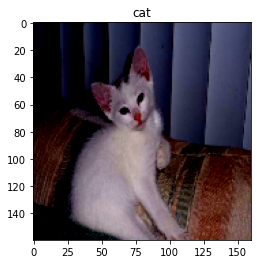

In [15]:
for image, label in train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [16]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [17]:
for img, label in raw_train.take(2):
    print("Original shape:", img.shape)

for img, label in train.take(2):
    print("New shape:", img.shape)

Original shape: (374, 336, 3)
Original shape: (375, 500, 3)
New shape: (160, 160, 3)
New shape: (160, 160, 3)


In [18]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [20]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 2s 104ms/step - loss: 0.7165 - accuracy: 0.5188


In [25]:
# Now we can train it on our images
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
582/582 [==============================] - 53s 91ms/step - loss: 0.2131 - accuracy: 0.9016 - val_loss: 0.0926 - val_accuracy: 0.9673
Epoch 2/3
582/582 [==============================] - 40s 69ms/step - loss: 0.0746 - accuracy: 0.9723 - val_loss: 0.0664 - val_accuracy: 0.9785
Epoch 3/3
582/582 [==============================] - 40s 69ms/step - loss: 0.0585 - accuracy: 0.9788 - val_loss: 0.0582 - val_accuracy: 0.9794
[0.9016120433807373, 0.9723266959190369, 0.9787748456001282]


In [26]:
model.save("dogs_vs_cats.h5")  # we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')

## Natural Language Processing

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence
import keras
import tensorflow as tf
import os
import numpy as np

VOCAB_SIZE = 88584

MAXLEN = 250
BATCH_SIZE = 64

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = VOCAB_SIZE)

Using TensorFlow backend.


In [3]:
train_data = sequence.pad_sequences(train_data, MAXLEN)
test_data = sequence.pad_sequences(test_data, MAXLEN)

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 32),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          2834688   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 2,843,041
Trainable params: 2,843,041
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=['acc'])

history = model.fit(train_data, train_labels, epochs=5, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 13s 22ms/step - loss: 0.4255 - acc: 0.8025 - val_loss: 0.3218 - val_acc: 0.8658
Epoch 2/5
625/625 [==============================] - 13s 21ms/step - loss: 0.2415 - acc: 0.9064 - val_loss: 0.3148 - val_acc: 0.8712
Epoch 3/5
625/625 [==============================] - 13s 21ms/step - loss: 0.1849 - acc: 0.9330 - val_loss: 0.3256 - val_acc: 0.8816
Epoch 4/5
625/625 [==============================] - 13s 21ms/step - loss: 0.1532 - acc: 0.9443 - val_loss: 0.3032 - val_acc: 0.8788
Epoch 5/5
625/625 [==============================] - 13s 21ms/step - loss: 0.1325 - acc: 0.9548 - val_loss: 0.3381 - val_acc: 0.8846


In [6]:
word_index = imdb.get_word_index()

def encode_text(text):
    tokens = keras.preprocessing.text.text_to_word_sequence(text)
    tokens = [word_index[word] if word in word_index else 0 for word in tokens]
    return sequence.pad_sequences([tokens], MAXLEN)[0]

text = "that movie was just amazing, so amazing"
encoded = encode_text(text)
print(encoded)


1646592/1641221 [==============================] - 1s 1us/step
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [10]:
# while were at it lets make a decode function

reverse_word_index = {value: key for (key, value) in word_index.items()}

def decode_integers(integers):
    PAD = 0
    text = ""
    for num in integers:
        if num != PAD:
            text += reverse_word_index[num] + " "

    return text[:-1]
  
print(decode_integers(encoded))

that movie was just amazing so amazing


In [11]:
# now time to make a prediction

def predict(text):
    encoded_text = encode_text(text)
    pred = np.zeros((1,250))
    pred[0] = encoded_text
    result = model.predict(pred) 
    print(result[0])

positive_review = "That movie was! really loved it and would great watch it again because it was amazingly great"
predict(positive_review)

negative_review = "that movie really sucked. I hated it and wouldn't watch it again. Was one of the worst things I've ever watched"
predict(negative_review)

[0.8587637]
[0.29387632]
